In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

df = pd.read_csv("updated_emotion_dataset.csv")
if df['label'].dtype not in [np.int64, np.int32]:
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
else:
    label_encoder = None  
    

C:\Users\kshit\AppData\Local\Temp\ipykernel_2596\3278789827.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


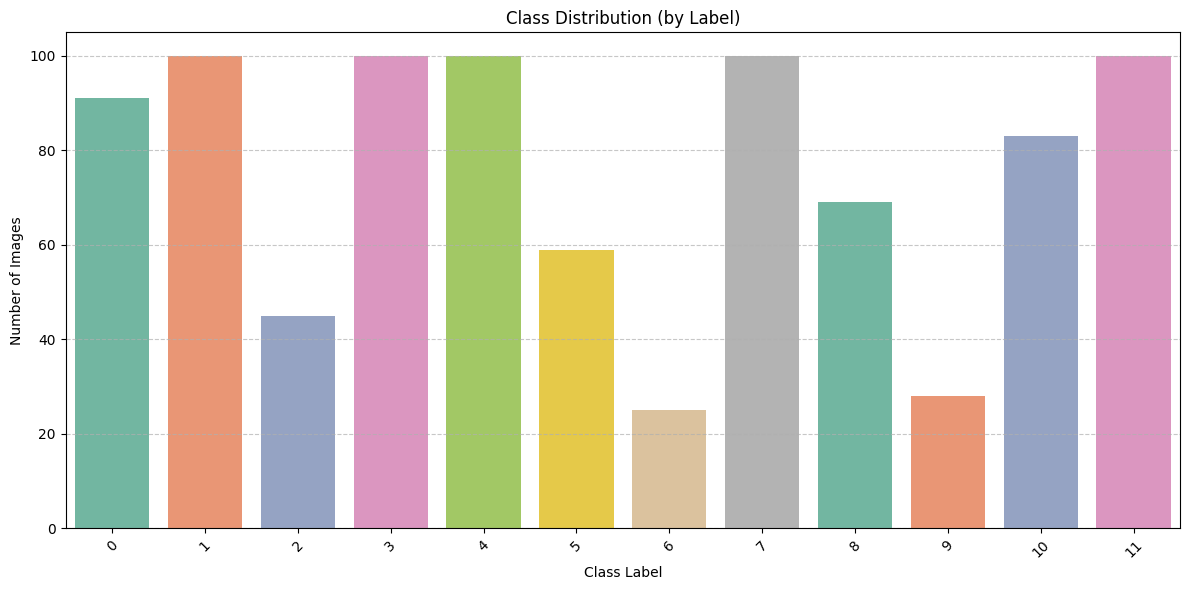

In [2]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Class Distribution (by Label)")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
target_count = 100
new_rows = []
counts = df['label'].value_counts().to_dict()
for cls, count in counts.items():
    if count < target_count:
        needed = target_count - count
        samples = df[df['label'] == cls].sample(needed, replace=True, random_state=1)
        new_rows.append(samples)
if new_rows:
    df_aug = pd.concat([df] + new_rows, ignore_index=True)
else:
    df_aug = df.copy()

print("\nClass distribution after oversampling to target:")
print(df_aug['label'].value_counts())


Class distribution after oversampling to target:
label
11    100
0     100
10    100
7     100
1     100
8     100
3     100
9     100
2     100
4     100
6     100
5     100
Name: count, dtype: int64


In [4]:
import os

base_dir = 'datasets'
df_aug['filepath'] = df_aug['image_name'].apply(
    lambda x: os.path.join(base_dir, 'ck_images', x) if 'ck_image' in x else os.path.join(base_dir, 'emo135_images', x)
)


In [5]:
X = df_aug['filepath'].to_numpy()
y = df_aug['label'].to_numpy()
num_classes = len(np.unique(y))

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.x = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.x[index]
        img = Image.open(img_path).convert('L')  # grayscale
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, int(self.y[index])

    def __len__(self):
        return len(self.x)

# --- 5. Define transforms ---

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
    ], p=0.7),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale -> 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [7]:
batch_size = 32

train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vit_l_32(pretrained=True)
model.heads.head = nn.Sequential(
    nn.Dropout(0.4),  # Extra dropout
    nn.Linear(model.heads.head.in_features, num_classes)
)
model = model.to(device)

C:\Users\kshit\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kshit\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.4)


def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [10]:
# --- 11. Training loop with early stopping ---

epochs = 50
best_val_acc = 0
patience = 10
bad_epochs = 0
best_model_wts = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True, ncols=100)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        if random.random() > 0.3:  # 70% chance to do mixup
            mixed_imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=0.3)
            outputs = model(mixed_imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            preds = outputs.argmax(dim=1)
            correct += (lam * preds.eq(y_a).sum().item() + (1 - lam) * preds.eq(y_b).sum().item())
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        total += labels.size(0)

    train_acc = correct / total
    loop.set_postfix(loss=running_loss / total, accuracy=correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)3
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/50: 100%|███████████████████████████████████████████████████| 30/30 [13:19<00:00, 26.67s/it]


Epoch  1 | Train Acc: 0.2531 | Val Acc: 0.4542


Epoch 2/50: 100%|███████████████████████████████████████████████████| 30/30 [13:09<00:00, 26.33s/it]


Epoch  2 | Train Acc: 0.4718 | Val Acc: 0.5667


Epoch 3/50: 100%|███████████████████████████████████████████████████| 30/30 [13:13<00:00, 26.46s/it]


Epoch  3 | Train Acc: 0.5780 | Val Acc: 0.6542


Epoch 4/50: 100%|███████████████████████████████████████████████████| 30/30 [13:13<00:00, 26.43s/it]


Epoch  4 | Train Acc: 0.6095 | Val Acc: 0.7125


Epoch 5/50: 100%|███████████████████████████████████████████████████| 30/30 [13:38<00:00, 27.30s/it]


Epoch  5 | Train Acc: 0.6969 | Val Acc: 0.7250


Epoch 6/50: 100%|███████████████████████████████████████████████████| 30/30 [13:58<00:00, 27.94s/it]


Epoch  6 | Train Acc: 0.7103 | Val Acc: 0.7250


Epoch 7/50: 100%|███████████████████████████████████████████████████| 30/30 [13:37<00:00, 27.25s/it]


Epoch  7 | Train Acc: 0.7151 | Val Acc: 0.7208


Epoch 8/50: 100%|███████████████████████████████████████████████████| 30/30 [13:39<00:00, 27.31s/it]


Epoch  8 | Train Acc: 0.7269 | Val Acc: 0.7417


Epoch 9/50: 100%|███████████████████████████████████████████████████| 30/30 [13:40<00:00, 27.35s/it]


Epoch  9 | Train Acc: 0.8218 | Val Acc: 0.7375


Epoch 10/50: 100%|██████████████████████████████████████████████████| 30/30 [14:13<00:00, 28.46s/it]


Epoch 10 | Train Acc: 0.8132 | Val Acc: 0.7417


Epoch 11/50: 100%|██████████████████████████████████████████████████| 30/30 [13:40<00:00, 27.34s/it]


Epoch 11 | Train Acc: 0.7784 | Val Acc: 0.7333


Epoch 12/50: 100%|██████████████████████████████████████████████████| 30/30 [13:42<00:00, 27.43s/it]


Epoch 12 | Train Acc: 0.8488 | Val Acc: 0.7417


Epoch 13/50: 100%|██████████████████████████████████████████████████| 30/30 [13:43<00:00, 27.44s/it]


Epoch 13 | Train Acc: 0.7582 | Val Acc: 0.7458


Epoch 14/50: 100%|██████████████████████████████████████████████████| 30/30 [13:43<00:00, 27.43s/it]


Epoch 14 | Train Acc: 0.8174 | Val Acc: 0.7542


Epoch 15/50: 100%|██████████████████████████████████████████████████| 30/30 [13:37<00:00, 27.25s/it]


Epoch 15 | Train Acc: 0.8837 | Val Acc: 0.7000


Epoch 16/50: 100%|██████████████████████████████████████████████████| 30/30 [13:43<00:00, 27.44s/it]


Epoch 16 | Train Acc: 0.8863 | Val Acc: 0.7042


Epoch 17/50: 100%|██████████████████████████████████████████████████| 30/30 [13:42<00:00, 27.41s/it]


Epoch 17 | Train Acc: 0.8386 | Val Acc: 0.7583


Epoch 18/50: 100%|██████████████████████████████████████████████████| 30/30 [13:42<00:00, 27.43s/it]


Epoch 18 | Train Acc: 0.8302 | Val Acc: 0.7042


Epoch 19/50: 100%|██████████████████████████████████████████████████| 30/30 [13:42<00:00, 27.43s/it]


Epoch 19 | Train Acc: 0.8459 | Val Acc: 0.7125


Epoch 20/50: 100%|██████████████████████████████████████████████████| 30/30 [13:34<00:00, 27.14s/it]


Epoch 20 | Train Acc: 0.7737 | Val Acc: 0.7250


Epoch 21/50: 100%|██████████████████████████████████████████████████| 30/30 [13:42<00:00, 27.40s/it]


Epoch 21 | Train Acc: 0.9059 | Val Acc: 0.7250


Epoch 22/50: 100%|██████████████████████████████████████████████████| 30/30 [14:07<00:00, 28.26s/it]


Epoch 22 | Train Acc: 0.8746 | Val Acc: 0.7375


Epoch 23/50: 100%|██████████████████████████████████████████████████| 30/30 [13:37<00:00, 27.24s/it]


Epoch 23 | Train Acc: 0.9164 | Val Acc: 0.7417


Epoch 24/50: 100%|██████████████████████████████████████████████████| 30/30 [13:41<00:00, 27.39s/it]


Epoch 24 | Train Acc: 0.8920 | Val Acc: 0.7333


Epoch 25/50: 100%|██████████████████████████████████████████████████| 30/30 [13:34<00:00, 27.14s/it]


Epoch 25 | Train Acc: 0.8454 | Val Acc: 0.7333


Epoch 26/50: 100%|██████████████████████████████████████████████████| 30/30 [13:34<00:00, 27.13s/it]


Epoch 26 | Train Acc: 0.8918 | Val Acc: 0.7458


Epoch 27/50: 100%|██████████████████████████████████████████████████| 30/30 [13:40<00:00, 27.34s/it]


Epoch 27 | Train Acc: 0.8534 | Val Acc: 0.7500
Early stopping at epoch 27


In [11]:
model.load_state_dict(best_model_wts)
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4615    0.3000    0.3636        20
           1     0.5500    0.5500    0.5500        20
           2     0.9524    1.0000    0.9756        20
           3     1.0000    0.9500    0.9744        20
           4     0.2857    0.4000    0.3333        20
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        20
           7     0.4000    0.2000    0.2667        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.0000    1.0000        20
          10     1.0000    1.0000    1.0000        20
          11     0.4138    0.6000    0.4898        20

    accuracy                         0.7500       240
   macro avg     0.7553    0.7500    0.7461       240
weighted avg     0.7553    0.7500    0.7461       240



In [12]:
torch.save(best_model_wts, 'best_model.pth')

In [13]:
model.eval()
train_correct, train_total = 0, 0
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

final_train_acc = train_correct / train_total
final_val_acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Train Accuracy: 0.9719
Final Validation Accuracy: 0.7500


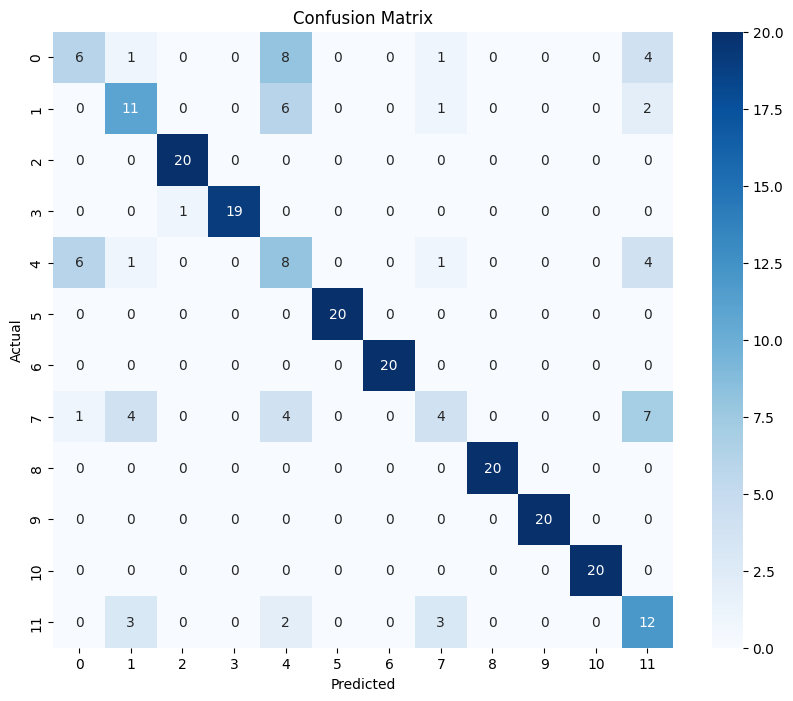

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()